In [2]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()


import sys
sys.path.append('/home/yves/Documents/')
import pGPFA



#  Ok now lets generate Poisson Data

In [56]:
y, params, t = pGPFA.genSim_data_static(n_neurons=50,
                                        nDims=3,
                                        pretty=False)

In [57]:
xtrue = params['latent_traj']

In [58]:
params['latent_traj'] = np.random.normal(size=params['latent_traj'].shape)

In [59]:
lapinfres = pGPFA.EM.E_step(y,params)

In [60]:
cmax = np.max(np.abs(lapinfres['post_cov']))/1.5

In [70]:
n_timePoints = params['t'].shape[0]


In [73]:
post_cov_by_timepoint  = np.zeros([n_timePoints,nDims,nDims])
for i in range(n_timePoints):
    post_cov_by_timepoint[i] = lapinfres['post_cov'][i*nDims:(i+1)*nDims,i*nDims:(i+1)*nDims]

(-1, 50)

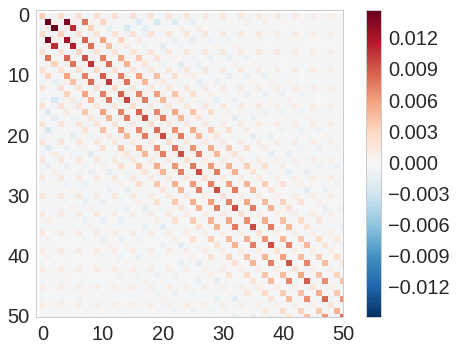

In [65]:
plt.imshow(lapinfres['post_cov'],cmap='RdBu_r',interpolation='None',vmin=-cmax,vmax=cmax)
plt.colorbar()
plt.grid()
plt.ylim(50,-1)
plt.xlim(-1,50)

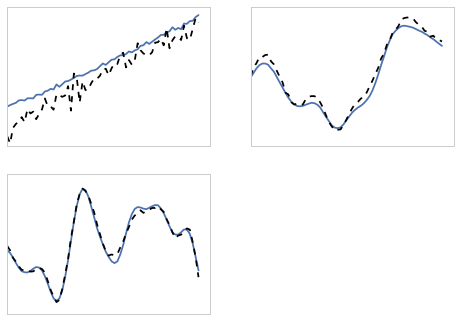

In [63]:
nDims = params['latent_traj'].shape[0]
nRows =nCols = np.ceil(np.sqrt(nDims))
for i in range(nDims):
    plt.subplot(nRows,nCols,i+1)
    plt.plot(lapinfres['post_mean'][i])
    plt.plot(xtrue[i],'--',color='k')
    plt.xticks([])
    plt.yticks([])



In [77]:
nDims = params['latent_traj'].shape[0]
x = params['latent_traj']

In [78]:
C = params['C']

In [79]:
K_big,_ = pGPFA._util.make_Kbig(params,t,nDims)  #this is the prior covariance of the GP latent state
C_big = pGPFA._util.make_Cbig(C,t)

In [80]:
xbar = np.array([x.T.flatten()]).T
ybar = np.array([y.T.flatten()])

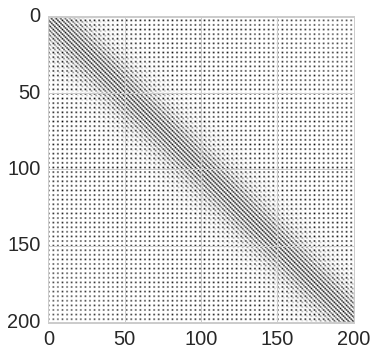

In [81]:
plt.imshow(K_big)

In [82]:
nT = len(t)

In [83]:
xInit = np.zeros(nDims*nT)

In [84]:
K_bigInv = np.linalg.inv(K_big+np.eye(K_big.shape[0])*1e-3)

In [85]:
d = params['d']
n_neurons = y.shape[0]

In [86]:
n_neurons

50

In [87]:
####
import scipy.optimize as op
import scipy as sp
resLap = op.minimize(
    fun = pGPFA._lapinf.lap_post_unNorm,
    x0 = xInit,
    method='Newton-CG',
    args = (ybar, C_big, d, K_bigInv,t,n_neurons),
    jac = pGPFA._lapinf.lap_post_grad,
    hess = pGPFA._lapinf.lap_post_hess,
    options = {'disp': False,'maxiter': 10000,'xtol':1e-32
})

In [88]:
x_post_mean = resLap.x.reshape(nDims,nT,order='F')

hess = pGPFA._lapinf.lap_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
PostCovGP = np.linalg.inv(hess)

PostCovGP = PostCovGP 
SD2 = 2*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))

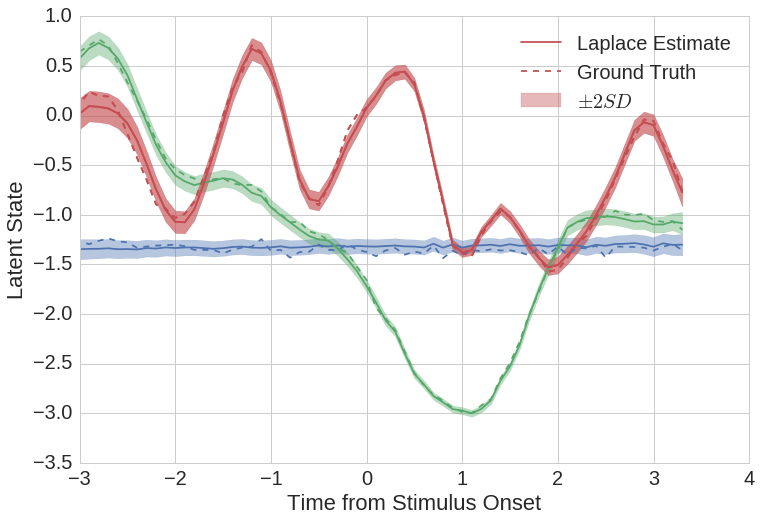

In [89]:
plt.figure(figsize=(12,8))
clrs = seaborn.color_palette('deep',n_colors=nDims+1,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(x_post_mean,x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3,)
plt.legend(loc='best')

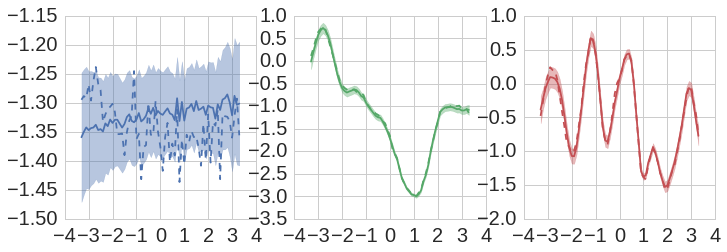

In [90]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(x_post_mean,x):
    plt.subplot(2,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
#plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
#plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
#plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

#plt.ylabel('Latent State')
#plt.xlabel('Time from Stimulus Onset')
#plt.xlim(-3,)
#plt.legend(loc='best')

## Plot Some Real and Smoothing out spike Rates

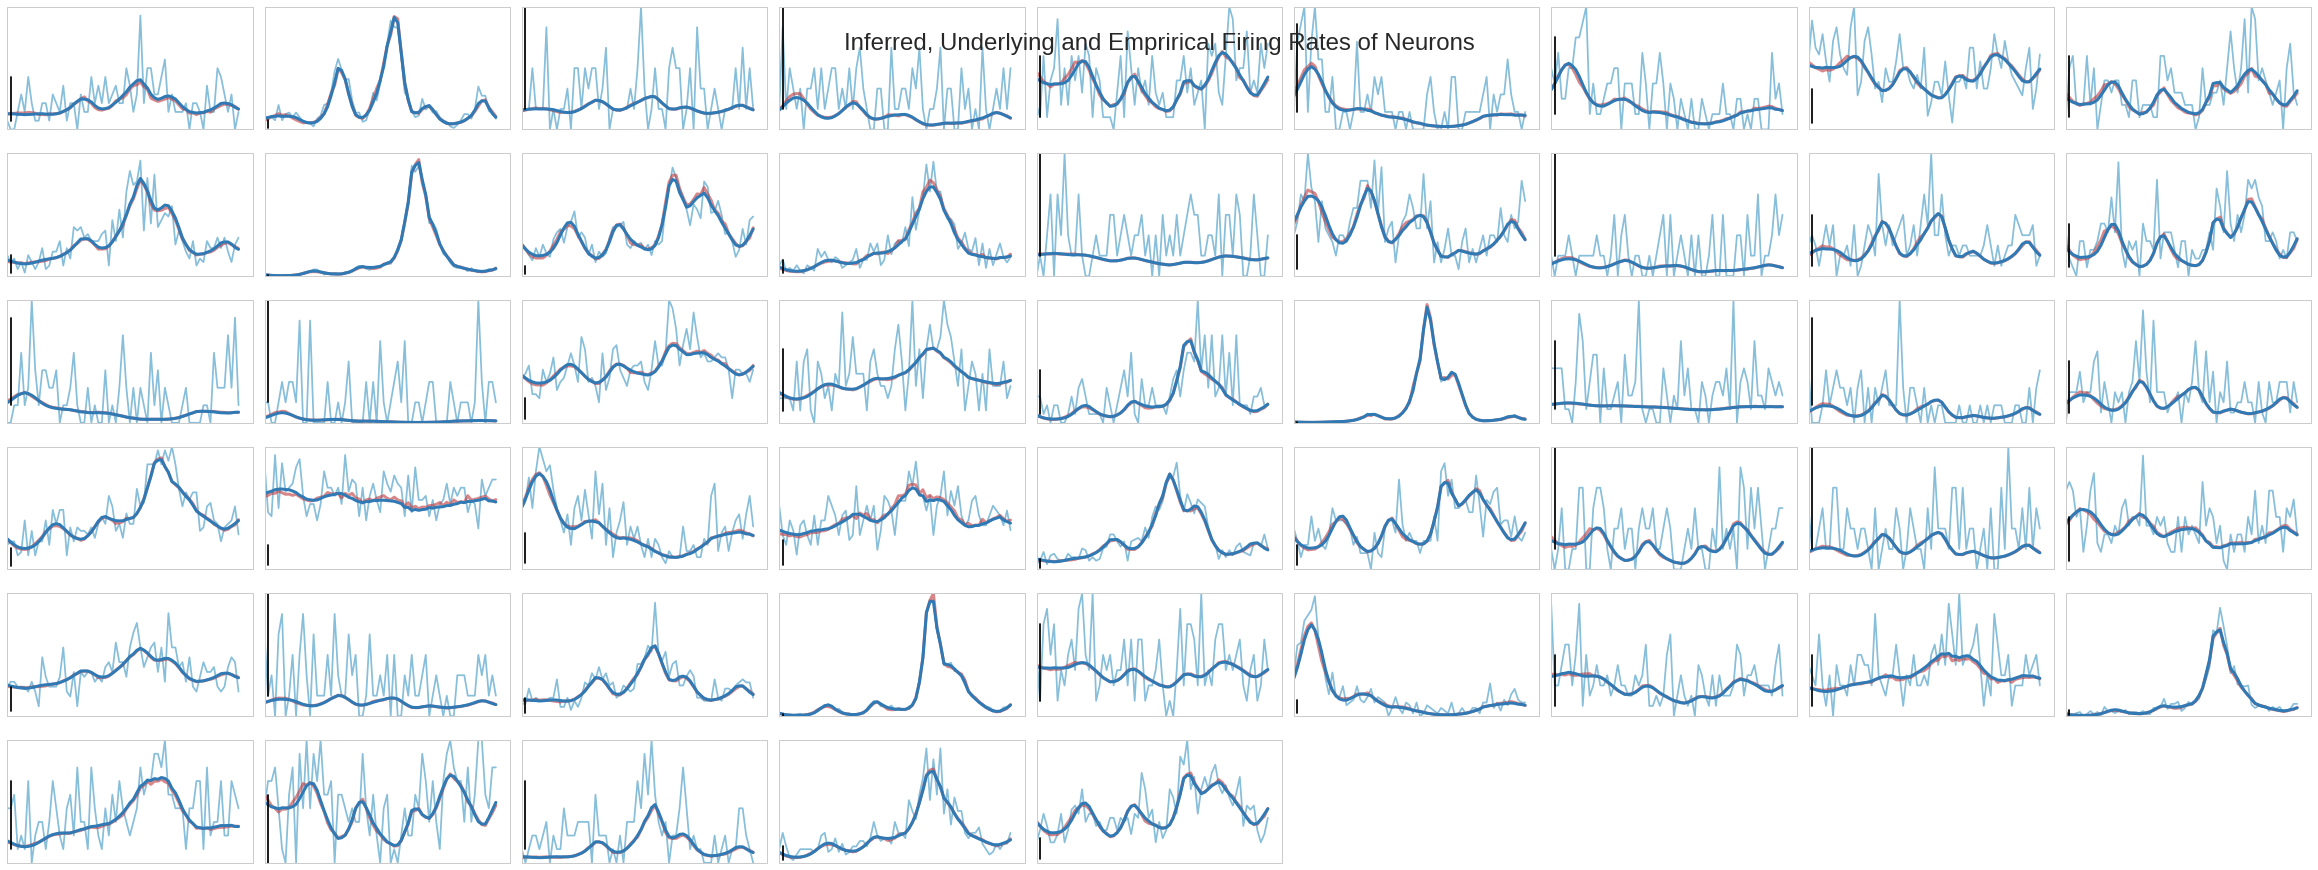

In [92]:
#newN = n.T.reshape(-1,67,order='F')
plt.figure(figsize=(32,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows = nCols = np.ceil(np.sqrt(n_neurons)) + 1

#nRows, nCols= 12,12

tt = 0
for real,sim in zip(params['CIFs'],np.exp(C.dot(x_post_mean).T+d).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(real,color=clrs[0],linewidth=3,alpha=0.6)
        plt.plot(sim,color=clrs[-1],linewidth=3)
        plt.plot([1,1],[1,6],color='k')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        #plt.legend()
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


# Now check gradients

In [60]:
x2 =np.random.normal(size=x.shape)

In [61]:
xbar2 = x2.T.flatten()

In [62]:
r2 = op.approx_fprime(np.squeeze(xbar2),
                pGPFA._lapinf.lap_post_unNorm,
                1e-6,
                ybar,C_big,d,K_bigInv,t,n_neurons)

In [63]:
r1 = pGPFA._lapinf.lap_post_grad(np.squeeze(xbar2),ybar,C_big,d,K_bigInv,t,n_neurons)

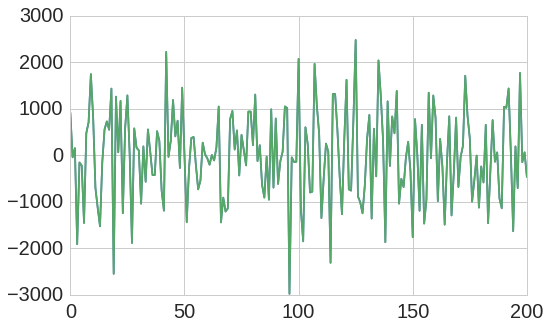

In [64]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(r1)
plt.plot(r2)


In [65]:
np.sum(r1-r2)

-0.087301910517040504

In [66]:
np.corrcoef(r1,r2)

array([[ 1.,  1.],
       [ 1.,  1.]])

In [67]:
from numpy.linalg import norm

In [28]:
norm(r1-r2)/norm(r1+r2)

0.52981270664946101

# Check Hessian

In [69]:
from statsmodels.tools.numdiff import approx_hess1, approx_hess2

In [70]:
xbar2 =np.random.normal(size=xbar.shape)

In [71]:
calculate_cost_function = pGPFA._lapinf.lap_post_unNorm

In [72]:
h = approx_hess2(np.squeeze(xbar2),pGPFA._lapinf.lap_post_unNorm,1e-2,(ybar,C_big,d,K_bigInv,t,n_neurons))

In [73]:
h2 = pGPFA._lapinf.lap_post_hess(xbar2,ybar,C_big,d,K_bigInv,t,n_neurons)

In [74]:
h - h2

array([[  1.48440614e-03,   8.99936584e-05,   1.27536551e-03, ...,
         -7.66910979e-08,  -2.54658516e-07,  -7.27595761e-08],
       [  8.99936584e-05,   1.33693187e-03,   3.20582542e-04, ...,
          0.00000000e+00,  -7.31414929e-08,   1.45519152e-07],
       [  1.27536551e-03,   3.20582542e-04,   6.31406574e-03, ...,
         -3.63797881e-08,  -1.45519152e-07,   8.12564076e-08],
       ..., 
       [ -7.66979831e-08,   0.00000000e+00,  -3.63797881e-08, ...,
          1.28296239e-03,   1.24081493e-04,   8.35714113e-04],
       [ -2.54658516e-07,  -7.31414772e-08,  -1.45519152e-07, ...,
          1.24081493e-04,   1.07076881e-03,  -2.94664752e-05],
       [ -7.27595761e-08,   1.45519152e-07,   8.12564078e-08, ...,
          8.35714113e-04,  -2.94664752e-05,   3.55824837e-03]])

In [75]:
np.linalg.norm(h-h2)/np.linalg.norm(h+h2)

1.983078939807441e-06